# Computation of the efficienvy vs rejection for ds blobs


### Nov 2020, JAH

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import hipy.hfit         as hfit

import bes.bes           as bes

In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Tue Nov 17 12:42:45 2020


### load data

In [5]:
def get_filename(run_number):
    datadir    = f"/data_extra2/jrenner/analysis/NEW"
    run_number = str(run_number)
    filename   = datadir + f'/{run_number}' + f'/hdf5/cdst/trigger2/cdst_combined_{run_number}' + '.h5'
    return filename

In [6]:
runs      = [8182, 8183, 8184] 
filenames = [get_filename(run) for run in runs]
dft       = bes.get_dft(filenames)

data filename:  /data_extra2/jrenner/analysis/NEW/8182/hdf5/cdst/trigger2/cdst_combined_8182.h5
data filename:  /data_extra2/jrenner/analysis/NEW/8183/hdf5/cdst/trigger2/cdst_combined_8183.h5
data filename:  /data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_combined_8184.h5


### selections and ranges

In [7]:
ranges     = bes.get_ranges()
for key in ranges.keys():
    print(key, ranges[key])

numb_of_tracks.one (0.5, 1.5)
energy (0.0, 3.0)
energy.cs (0.65, 0.71)
energy.ds (1.55, 1.75)
energy.ph (2.5, 3.0)
enecor.cs (0.65, 0.71)
enecor.ds (1.55, 1.75)
enecor.ph (2.5, 3.0)
z_min (50.0, 500.0)
z_max (50.0, 500.0)
r_max (0.0, 180.0)
dz_track.cs (8.0, 32.0)
dz_track.ds (24.0, 72.0)
dz_track.ph (35.0, 130.0)


In [9]:
selections = bes.Selections(dft, ranges)
selections.logical_and(('numb_of_tracks.one', 'z_min', 'z_max', 'r_max', 'energy'), 'fidutial')
print(selections)

numb_of_tracks.one : numb_of_tracks [0.5, 1.5],  entries 1592300, efficiency 0.69813
energy : energy [0.0, 3.0],  entries 2280632, efficiency 0.99992
energy.cs : energy [0.65, 0.71],  entries 57367, efficiency 0.02515
energy.ds : energy [1.55, 1.75],  entries 19389, efficiency 0.00850
energy.ph : energy [2.5, 3.0],  entries 1093, efficiency 0.00048
enecor.cs : enecor [0.65, 0.71],  entries 59294, efficiency 0.02600
enecor.ds : enecor [1.55, 1.75],  entries 19599, efficiency 0.00859
enecor.ph : enecor [2.5, 3.0],  entries 1769, efficiency 0.00078
z_min : z_min [50.0, 500.0],  entries 1962720, efficiency 0.86053
z_max : z_max [50.0, 500.0],  entries 1983913, efficiency 0.86982
r_max : r_max [0.0, 180.0],  entries 1706589, efficiency 0.74823
dz_track.cs : dz_track [8.0, 32.0],  entries 894445, efficiency 0.39216
dz_track.ds : dz_track [24.0, 72.0],  entries 157370, efficiency 0.06900
dz_track.ph : dz_track [35.0, 130.0],  entries 84943, efficiency 0.03724
fidutial : numb_of_tracks [0.5, 1

## Energy 

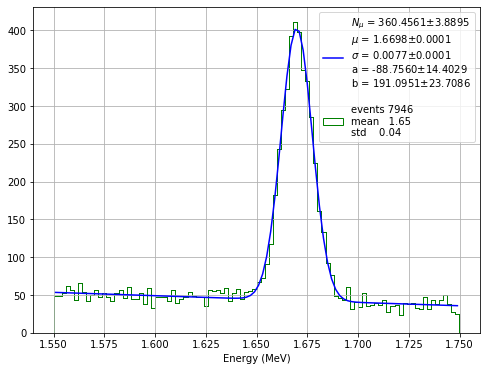

In [10]:
xsel = selections.logical_and(('enecor.ds', 'fidutial'))

pars0 = [ 40.,  1.7, 0.01,  1., 100.]
bins  = 100
enes = dft[xsel].enecor

pltext.canvas(1, 1, 6, 8)

pars, upars = pltext.hfit(enes, bins, 'gausline', pars0, formate = '6.4f');
pltext.hist(enes, 100)
plt.xlabel('Energy (MeV)')

ng, mu, sigma, a, b = pars

In [11]:
def ds_energy_fit(enes, pars, bins = 100, fix_gaussian = False, plot = False):
    
    ng, mu, sigma, a, b = pars
    
    ffit = lambda x, na, a, b : hfit.fgausline(x, na, mu, sigma, a, b) 
    ffun  = ffit if fix_gaussian else hfit.fgausline
    
    pars0 = (pars[1], pars[3], pars[4]) if fix_gaussian else pars
        
    pars, upars = hfit.hfit(enes, bins, ffun, pars0);
    
    if (plot):
         pltext.hfit(enes, bins, ffun, pars0, formate = '6.3f');
    
    if (fix_gaussian):
        ng, a, b    = pars
        ung, ua, ub = upars
        pars  = (ng, mu, sigma, a, b)
        upars = (ung, 0., 0., ua, ub) 
    
    return pars, upars
    
def ds_signal_bkg(enes, pars, bins = 100, nsigmas = 3, plot = False):
    
    ng, mu, sigma, a, b = pars

    fline = lambda x: hfit.fline(x, a, b)
    fgaus = lambda x: hfit.fgaus(x, ng, mu, sigma)

    nsigmas = 3
    erange =  (mu - nsigmas * sigma, mu + nsigmas * sigma)

    ys, xs = np.histogram(enes, bins)
    xcs    = ut.centers(xs)

    csel = ut.in_range(xcs, erange)
    xcs1 = xcs [csel]

    signal = np.array([fgaus(xi) for xi in xcs1])
    bkg    = np.array([fline(xi) for xi in xcs1])
    
    if (plot is not None):        
        plt.plot(xcs1, signal)
        plt.plot(xcs1, bkg)
        plt.plot(xcs1, signal + bkg)
        plt.plot(xcs[csel], ys[csel], ls = '', marker = 'o');
    
    return np.sum(signal), np.sum(bkg)

initial parameters  : [40.0, 1.7, 0.01, 1.0, 100.0]
expected parameters : [ 3.60456140e+02  1.66978444e+00  7.70321929e-03 -8.87559812e+01
  1.91095085e+02]


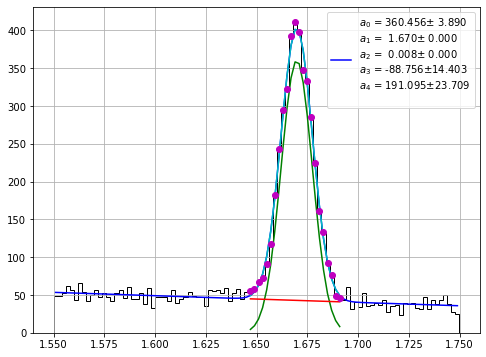

In [12]:
pltext.canvas(1, 1, 6, 8)
enes = dft[xsel].enecor
print('initial parameters  :', pars0)
pars, upars = ds_energy_fit(enes, pars0, plot = True)
signal, bkg = ds_signal_bkg(enes, pars , plot = True)
print('expected parameters :', pars)
mu, sigma = pars[1], pars[2]

## efficiency vs rejection as a function of the 2nd blob energy

In [13]:
pars_guess  = [40., 1.672, 0.0087, 1., 100.]

def ds_eblob_eff(eblob2_cuts, xsel, pars0 = pars_guess):

    nsigs, nbkgs = [], []

    subplot = pltext.canvas(len(eblob2_cuts))

    for i, ecut in enumerate(eblob2_cuts):

        subplot(i + 1)
        ysel = xsel & ut.in_range(dft.eblob2, (ecut, 0.6))
    
        enes = dft[ysel].enecor
        fix_gaussian = i > 0
        pars, upars = ds_energy_fit(enes, pars0, fix_gaussian = fix_gaussian, plot = True)
        nsig, nbkg  = ds_signal_bkg(enes, pars, plot = True)
        plt.title('ebloe2 > {0:4.3f}'.format(ecut));
        pars0 = pars
        #print(pars0)
        nsigs.append(nsig)
        nbkgs.append(nbkg)
        
    return nsigs, nbkgs

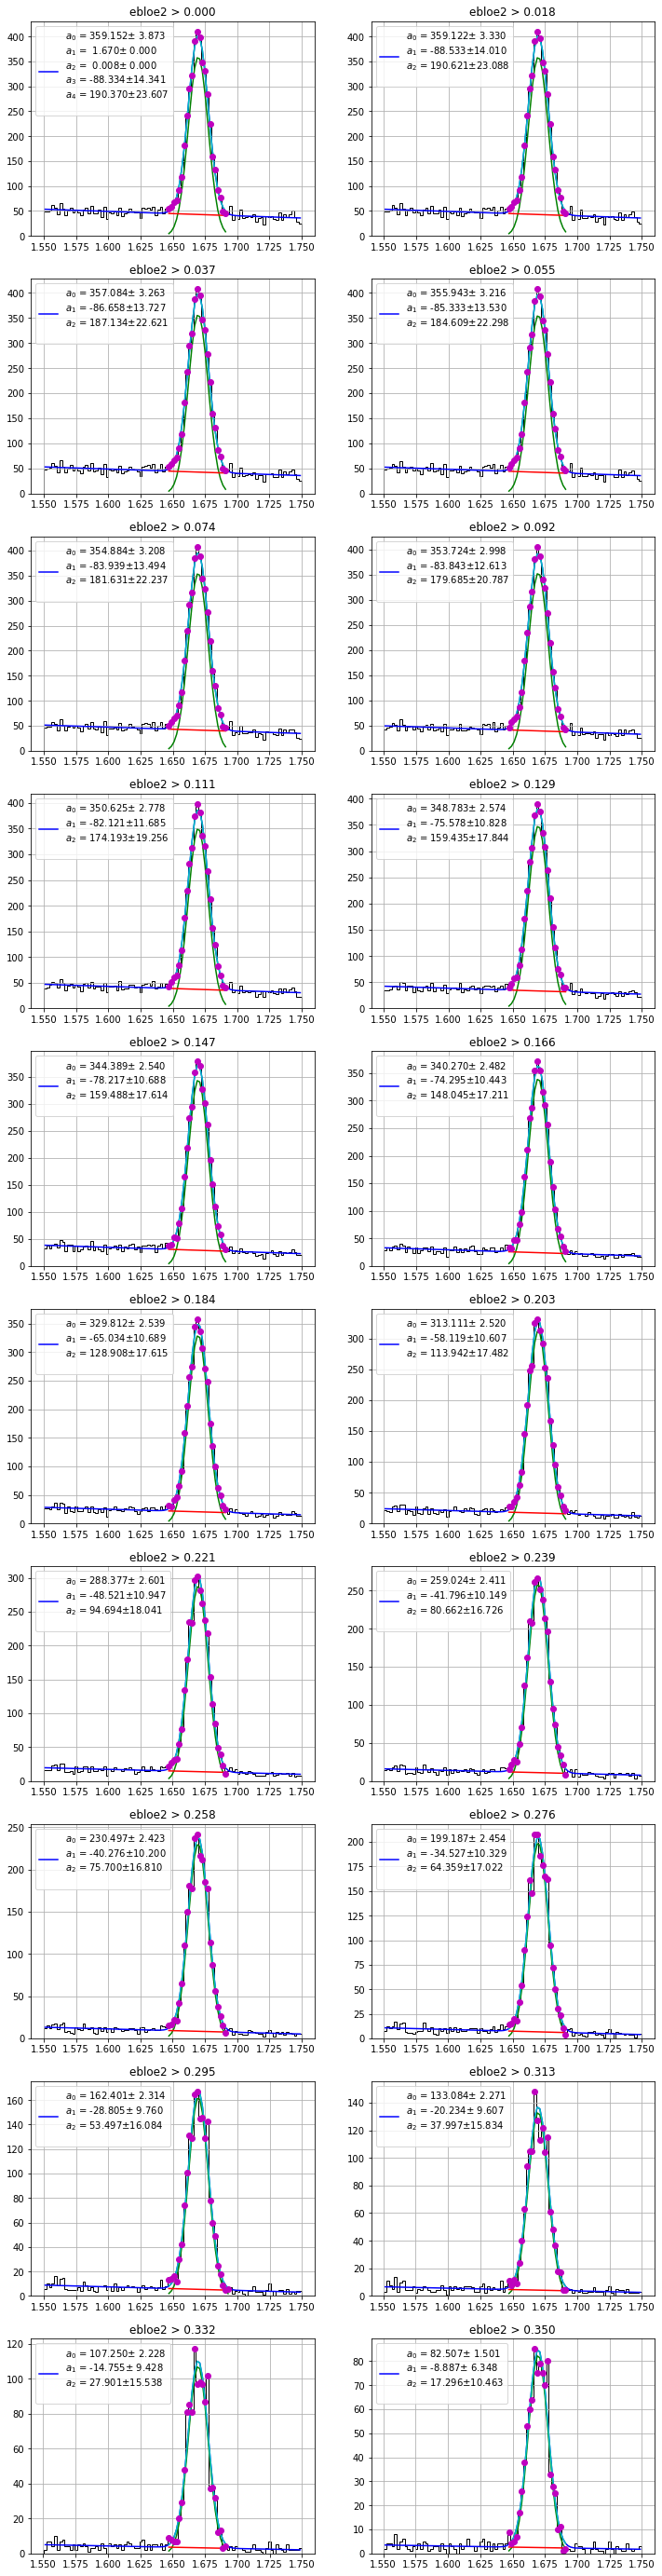

In [15]:
eblob2_cuts = np.linspace(0., 0.35, 20) 
xsel        = selections.logical_and(('fidutial', 'enecor.ds'))
nsigs, nbkgs = ds_eblob_eff(eblob2_cuts, xsel, pars_guess)

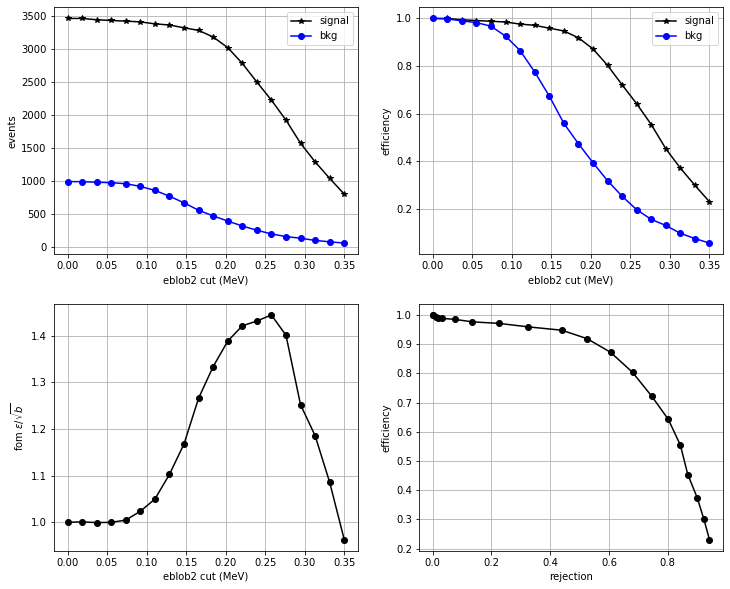

In [16]:
subplot = pltext.canvas(4)

subplot(1)
plt.plot(eblob2_cuts, nsigs, marker = '*', label = 'signal');
plt.plot(eblob2_cuts, nbkgs, marker = 'o', label = 'bkg') 
plt.xlabel('eblob2 cut (MeV)'); plt.ylabel('events'); plt.legend(); plt.grid(); #plt.yscale('log')

subplot(2)
plt.plot(eblob2_cuts, nsigs/nsigs[0], marker = '*', label = 'signal');
plt.plot(eblob2_cuts, nbkgs/nbkgs[0], marker = 'o', label = 'bkg')
plt.xlabel('eblob2 cut (MeV)'); plt.ylabel('efficiency'); plt.legend(); plt.grid();

subplot(3)
fom = (nsigs/nsigs[0]) / np.sqrt(nbkgs/nbkgs[0])
plt.plot(eblob2_cuts, fom, marker = 'o', label = 'signal');
plt.xlabel('eblob2 cut (MeV)'); plt.ylabel(r'fom $\epsilon/\sqrt{b}$'); plt.grid();

subplot(4)
plt.plot(1. - nbkgs/nbkgs[0], nsigs/nsigs[0], marker = 'o')
plt.xlabel('rejection'); plt.ylabel('efficiency'); plt.grid();

## blobs and length inside and outside bands

In [19]:
ranges['enecor.ds.left']   = (1.55, 1.63)
ranges['enecor.ds.center'] = (1.64, 1.79)
ranges['enecor.ds.right']  = (1.70, 1.75)
selections.set_range('enecor.ds.left'  , ranges['enecor.ds.left'])
selections.set_range('enecor.ds.center', ranges['enecor.ds.center'])
selections.set_range('enecor.ds.right' , ranges['enecor.ds.right'])

bands = ['enecor.ds.left', 'enecor.ds.center', 'enecor.ds.right']

In [20]:
print(list(dft.columns))

['event', 'trackID', 'energy', 'length', 'numb_of_voxels', 'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min', 'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave', 'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x', 'vox_size_y', 'vox_size_z', 'dz_track', 'enecor']


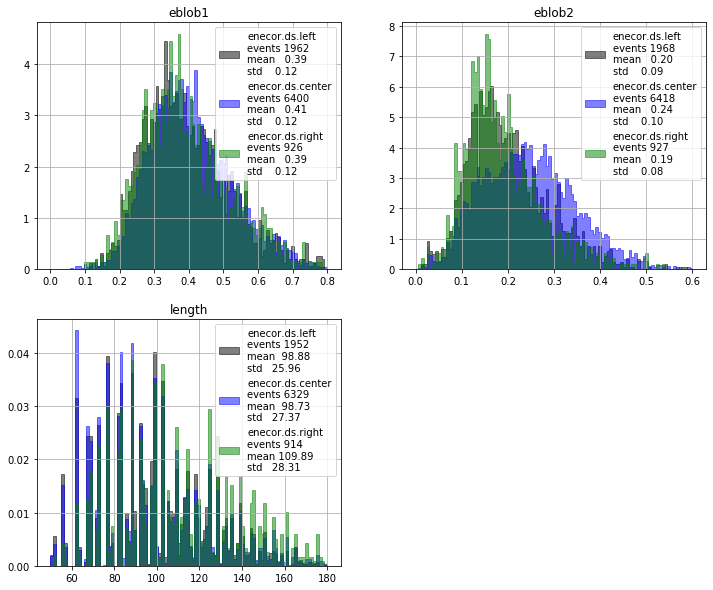

In [21]:
variables = ['eblob1', 'eblob2', 'length']
ranges['eblob1'] = (0., 0.8)
ranges['eblob2'] = (0., 0.6)
ranges['length'] = (50, 180.)
subplot   = pltext.canvas(len(variables))
bins      = 100

for i, variable in enumerate(variables):
    subplot(i + 1)
    for band in bands:
        xsel = selections.logical_and(('fidutial', band))
        vals = dft[xsel][variable]
        pltext.hist(vals, bins, label = band, density = True, range = ranges[variable], fill = True, alpha = 0.5)
    plt.title(variable)